In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from copy import copy

In [2]:
from Games import *
import Utility
from os import listdir, mkdir
from os.path import join, isdir
from json import load
from glob import glob

In [3]:
def switch_heatmap(dataframe, graph, bounds, player_name, reward_type, info):
    # heat map is only built for both reward
    max_x, max_y = bounds
    max_val = 0
    heatmap_data = {}
    
    if player_name == None:
        p_df = dataframe[dataframe['Reward Type'] == reward_type]
    else:
        p_df = dataframe[dataframe['Agent'] == player_name]
        p_df = p_df[p_df['Reward Type'] == reward_type]
    
    # This block of code finds the number of elites per grid cell. We
    # use this to average the heatmap
    counter = {}
    for node in graph.nodes:
        if '__' in node:
            continue

        a,b,_ = node.split(',')
        key = (int(b), int(a))
        if key in counter:
            counter[key] += 1
        else:
            counter[key] = 1
    
    # build entry in heatmap data 
    for name, d_df in p_df.groupby('Director'):
        min_level = 0
        heatmap_data[name] = [None, None]
        for index, percentage in enumerate([0.7, 0.3]):
            data = np.zeros((max_y+1, max_x+1))
            mask = np.ones((max_y+1, max_x+1))
            
            # filter for the correct split in levels
            old_min_level = min_level
            min_level += int((df.Level.max()+1)*percentage)
            r_df = d_df[d_df.Level.between(old_min_level-1, min_level)]
            
            # build the mask
            for n in graph.nodes:
                if '__' in n:
                    continue

                a,b,_ = n.split(',')
                mask[int(b)][int(a)] = 0.0

            # build heatmap occurrences for each node
            for i, row in r_df.iterrows():
                for n in row.Nodes:
                    if '__' in n:
                        continue

                    a, b, _ = n.split(',')
                    data[int(b)][int(a)] += 1.0

            # average the heatmap for the number of runs and cells
            for (y,x), count in counter.items():
                data[y][x] /= info['runs']*count
                max_val = max(data[y][x], max_val) 

            # store heatmap data
            heatmap_data[name][index] = (data, mask)
    
    fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(20,8))
    cbar_ax = fig.add_axes([.92, .1, .02, .77])
    
    ordered_directors = list(heatmap_data.keys())
    ordered_directors.sort()
    
    cmap = copy(plt.get_cmap('vlag'))
    cmap.set_under('gray')

    for i, director in enumerate(ordered_directors):
        for j in range(2):
            data, mask = heatmap_data[director][j]
            ax = sns.heatmap(
                data, 
                mask=mask,
                square=True,
                cmap=cmap,
                ax=axes[j,i],
                cbar_ax=None if i != 3 else cbar_ax,
                cbar=i==3,
                vmin=0.01,
                vmax=max_val
            )

            axes[j,i].invert_yaxis()
    #         axes[i].set_title(f'{director}', y=-0.1)
            axes[j,i].set_title(director)
            axes[j,i].set_facecolor("black")
            axes[j,i].set_xticks([])
            axes[j,i].set_yticks([])
            axes[j,i].set_aspect('auto')

            if i == 0:
                axes[j,i].set_ylabel('Leniency', fontsize=14)
    
    if player_name ==None:
        fig.suptitle(f'Switching Players Graph', fontsize=16, y=0.99)
    else:
        if 'Likes High A' in player_name:
            player_name = player_name.replace('High A', 'High Density')
        elif 'Likes High B' in player_name:
            player_name = player_name.replace('High B', 'High Leniency')
        
        fig.suptitle(f'{player_name} for {reward_type} Reward', fontsize=16, y=0.99)
        
    fig.text(0.5, 0.02, 'Density', ha='center', size=14)
    plt.show()

In [4]:
FIGURE = 'figure'
if not isdir(FIGURE):
    mkdir(FIGURE)

In [5]:
PALETTE = {
    "Policy": "red", 
    "Q": "blue", 
    "Random": "orange", 
    "Greedy": "green",
}

In [6]:
def heatmap(dataframe, graph, bounds, player_name, reward_type, info):
    # heat map is only built for both reward
    max_x, max_y = bounds
    max_val = 0
    heatmap_data = {}
    
    if player_name == None:
        p_df = dataframe[dataframe['Reward Type'] == reward_type]
    else:
        p_df = dataframe[dataframe['Agent'] == player_name]
        p_df = p_df[p_df['Reward Type'] == reward_type]
    
    # This block of code finds the number of elites per grid cell. We
    # use this to average the heatmap
    counter = {}
    for node in graph.nodes:
        if '__' in node:
            continue

        a,b,_ = node.split(',')
        key = (int(b), int(a))
        if key in counter:
            counter[key] += 1
        else:
            counter[key] = 1
    
    # build entry in heatmap data 
    for name, d_df in p_df.groupby('Director'):
        data = np.zeros((max_y+1, max_x+1))
        mask = np.ones((max_y+1, max_x+1))
        
        # build the mask
        for n in graph.nodes:
            if '__' in n:
                continue

            a,b,_ = n.split(',')
            mask[int(b)][int(a)] = 0.0
            
        # build heatmap occurrences for each node
        for i, row in d_df.iterrows():
            for n in row.Nodes:
                if '__' in n:
                    continue

                a, b, _ = n.split(',')
                data[int(b)][int(a)] += 1.0
                
        # average the heatmap for the number of runs and cells
        for (y,x), count in counter.items():
            data[y][x] /= info['runs']*count
            max_val = max(data[y][x], max_val) 
        
        # store heatmap data
        heatmap_data[name] = (data, mask)
    
    fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20,4))
    cbar_ax = fig.add_axes([.92, .1, .02, .77])
    
    ordered_directors = list(heatmap_data.keys())
    ordered_directors.sort()
    
    cmap = copy(plt.get_cmap('vlag'))
    cmap.set_under('gray')

    for i, director in enumerate(ordered_directors):
        data, mask = heatmap_data[director]
        ax = sns.heatmap(
            data, 
            mask=mask,
            square=True,
            cmap=cmap,
            ax=axes[i],
            cbar_ax=None if i != 3 else cbar_ax,
            cbar=i==3,
            vmin=0.01,
            vmax=max_val
        )
        
        axes[i].invert_yaxis()
#         axes[i].set_title(f'{director}', y=-0.1)
        axes[i].set_title(director)
        axes[i].set_facecolor("black")
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_aspect('auto')
        
        if i == 0:
            axes[i].set_ylabel('Leniency', fontsize=14)
    
    if player_name ==None:
        fig.suptitle(f'Switching Players Graph', fontsize=16, y=0.99)
        
    else:
        if 'Likes High A' in player_name:
            player_name = player_name.replace('High A', 'High Density')
        elif 'Likes High B' in player_name:
            player_name = player_name.replace('High B', 'High Leniency')
        
        fig.suptitle(f'{player_name} for {reward_type} Reward', fontsize=16, y=0.99)
    fig.text(0.5, 0.02, 'Density', ha='center', size=14)
    plt.show()

# Icarus Level Segments

In [7]:
def get_all_player_playthroughs(config, start):
    d = []
    for path in glob(join(config.BASE_DIR, f'{start}*reward_*.json')):
        path_split = path.split('/')[-1].split('_')
        player = path_split[1]
        director = path_split[-3]
        reward = path_split[-1].split('.')[0]
        
        with open(path, 'r') as f:
            temp = load(f)
            data = temp['data']
            info = temp['info']
        
        for i_session, session in enumerate(data):
            for i_run, run in enumerate(session):
                nodes = []
                for entry in run['Playthrough']:
                    nodes.append(entry['node_name'])
                    
                d.append((
                    reward, 
                    player, 
                    director,
                    i_run,
                    run['percent_complete'],
                    run['percent_design_reward'],
                    run['percent_player_reward'],
                    run['percent_total_reward'],
                    nodes
                ))
    
    labels = (
        'Reward Type', 
        'Agent', 
        'Director',
        'Level',
        'Percent Complete', 
        'Design Reward', 
        'Player Reward', 
        'Total Reward',
        'Nodes'
    )
    return pd.DataFrame(d, columns=labels), info

In [8]:
def plot_player_personas_over_time(df):

    # sort keys so the output is always in the same order
    player_names = list(df.Agent.unique())
    player_names.sort()
    
    reward_names = list(df['Reward Type'].unique())
    
    # build plots and set title
    fig, axes = plt.subplots(3, len(player_names), sharex=True, sharey=True, figsize=(20,12))
    fig.suptitle(f'Average Reward Per Level for Icarus', fontsize=16)
    
    # fill in each plot
    for y, name in enumerate(reward_names):
        for x, player in enumerate(player_names):
            g_df = df[df['Reward Type'] == name]
            g_df = g_df[g_df['Agent'] == player]

            ax = sns.lineplot(ax=axes[y, x], data=g_df, x='Level', y=REWARD_MAP[name], hue='Director', palette=PALETTE)
            ax.get_legend().remove()
            ax.set_xlabel('')
            
            if y == 0:
                if 'Likes High A' in player:
                    player = player.replace('High A', 'High Density')
                elif 'Likes High B' in player:
                    player = player.replace('High B', 'High Leniency')
                    
                ax.set_title('Likes\n'.join(player.split('Likes')), fontsize=12)
                
            if x == 0:
                ax.set_ylabel(name, fontsize=14)
            else:
                ax.set_ylabel('')
                
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', ncol=2, bbox_to_anchor=(.905, 0.99))
    fig.text(0.5, 0.08, 'Level', ha='center', size=14)
#     fig.text(0.08, 0.5, 'Reward', va='center', rotation='vertical', size=14)
    plt.show()

# Segments

In [9]:
config = Icarus
graph = Utility.get_level_segment_graph(config, True)

REWARD_MAP = {
    'DESIGNER': 'Design Reward',
    'PLAYER': 'Player Reward',
    'BOTH': 'Total Reward',
}

REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.DESIGNER)
df, info = get_all_player_playthroughs(config, 'player')

Loading links from: ./GramElitesData/IcarusData/gram_elites/links_True.json


KeyboardInterrupt: 

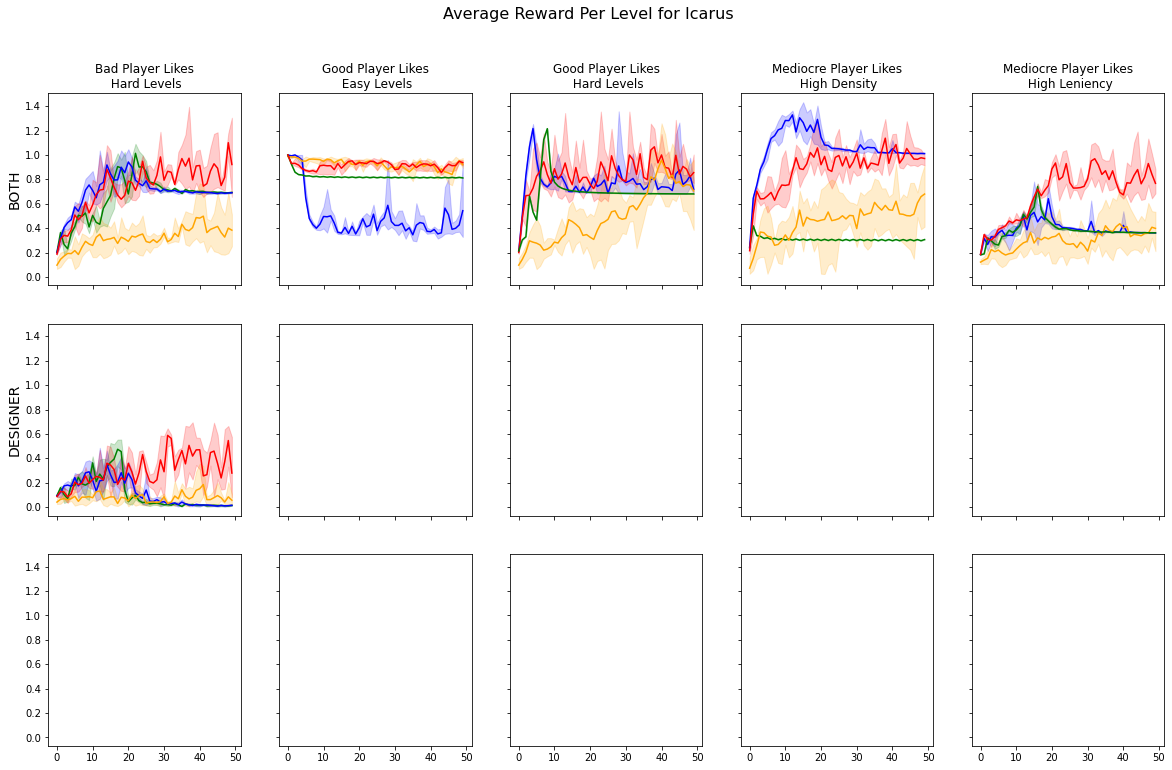

In [10]:
plot_player_personas_over_time(df)

In [ ]:
heatmap(df, graph, config.MAX_BC, 'Mediocre Player Likes High A', 'BOTH', info) 

In [ ]:
heatmap(df, graph, config.MAX_BC, 'Mediocre Player Likes High B', 'DESIGNER', info) 

In [ ]:
heatmap(df, graph, config.MAX_BC, 'Mediocre Player Likes High B', 'PLAYER', info) 

In [ ]:
heatmap(df, graph, config.MAX_BC, 'Good Player Likes Easy Levels', 'BOTH', info) 

# N-Gram

In [ ]:
config = Mario
graph = Utility.get_level_segment_graph(config, True)

rewards = ('Design Reward', 'Player Reward', 'Both Reward')

REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.DESIGNER)
df, info = get_all_player_playthroughs(config, 'player')

In [ ]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(20,4))
i = 0
for (rt, a), g_df in df.groupby(['Reward Type', 'Agent']):
    ax = sns.lineplot(ax=axes[i], data=g_df, x='Level', y=REWARD_MAP[rt], hue='Director', palette=PALETTE)
    axes[i].set_title(REWARD_MAP[rt])
    axes[i].set_ylabel('Reward',fontsize=14)
    axes[i].set_xlabel('')
    axes[i].get_legend().remove()
#     axes[i].tick_params(axis='both', which='both')
    axes[i].yaxis.set_tick_params(labelbottom=True)
    
    i += 1
    
handles, labels = ax.get_legend_handles_labels()   
fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(.97, 0.915))
fig.text(0.5, 0.01, 'Level', ha='center', size=14)
fig.suptitle(f'N-Gram Generation for Mario', fontsize=16,  y=0.99)
plt.show()

# Switching Players

In [17]:
config = Icarus
graph = Utility.get_level_segment_graph(config, True)

rewards = ('Design Reward', 'Player Reward', 'Both Reward')

REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.DESIGNER)
df, info = get_all_player_playthroughs(config, 'switch')

Loading links from: ./GramElitesData/IcarusData/gram_elites/links_True.json


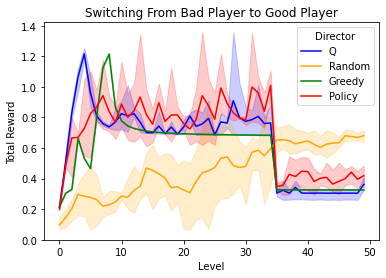

In [18]:
for (rt, a), g_df in df.groupby(['Reward Type', 'Agent']):
    sns.lineplot(data=g_df, x='Level', y=REWARD_MAP[rt], hue='Director', palette=PALETTE)
    plt.title(f'Switching From Bad Player to Good Player')
    plt.show()

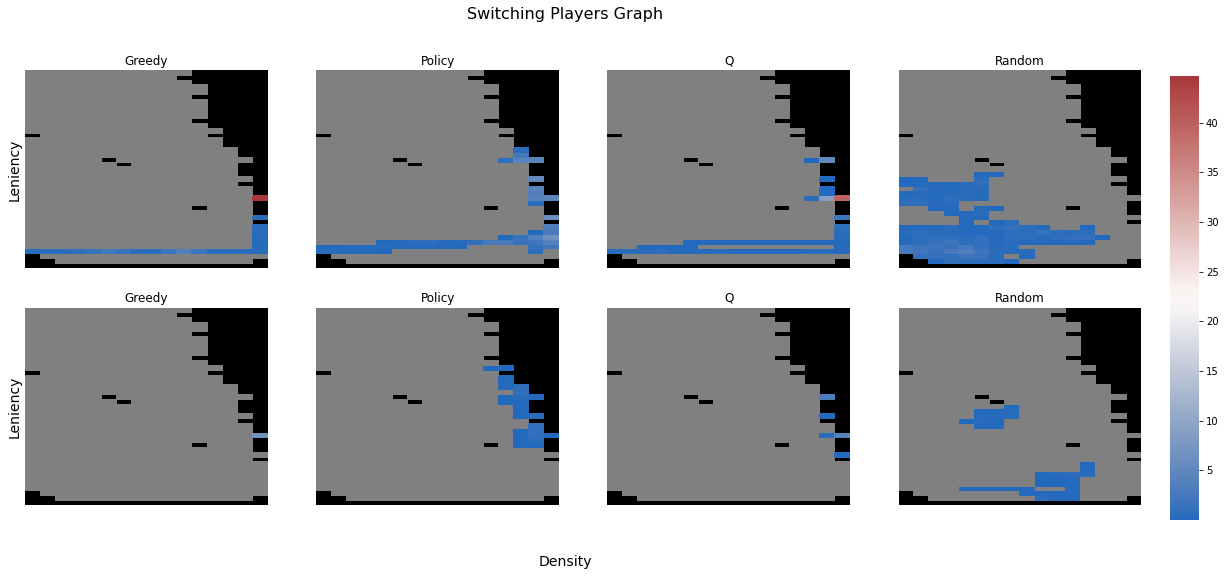

In [19]:
switch_heatmap(df, graph, config.MAX_BC, None, 'BOTH', info)